# Домашнее задание №2

In [1]:
import os
import numpy as np

## Заполнение словаря значениями затрат

Словарь хранит в себе значения затрат за один шаг вверх, направо и по диагонали соответственно. Отсутствие перехода обозначено отрицательным числом -1.

In [2]:
import ast

def input_values(m, n, no_value = -1, save_path = os.path.join('data', 'map_2.txt')):
    """
    Позволяет запонить словарь (ключ - координата) значениями затрат при соответстующем направлении, также заполняет txt файл
    """
    way_map = {(row, column): [no_value, no_value, no_value] for row in range(m) for column in range(n)}
    with open(save_path, 'w') as f:
        for key in way_map.keys():
            if key[1] < n - 1:
                print(f'{key}->{(key[0], key[1]+1)}:')
                way_map[key][1] = int(input())
                f.write(f'{key}->{(key[0], key[1]+1)}: {way_map[key][1]}\n' )
            if key[0] < m - 1:
                print(f'{key}->{(key[0]+1, key[1])}:')
                way_map[key][0] = int(input())
                f.write(f'{key}->{(key[0]+1, key[1])}: {way_map[key][0]}\n' )
            if key[0] < m - 1 and key[1] < n - 1:
                print(f'{key}->{(key[0]+1, key[1]+1)}:')
                way_map[key][2] = int(input())
                f.write(f'{key}->{(key[0]+1, key[1]+1)}: {way_map[key][2]}\n' )
        return way_map

    
    


def read_map(map_path = os.path.join('data', 'map_2.txt'), no_value = -1):
    """
    Считывает координаты точек и затраты из txt файла
    """
    result = dict()
    with open(map_path, 'r') as f:
        info = f.readline()
        while info.strip():
            info = info.strip()
            direction, length = [info_part.strip() for info_part in info.split(':')]
            begin, end = [ast.literal_eval(direction_part) for direction_part in direction.split('->')]
            
            if begin not in result:
                result[begin] = [no_value, no_value, no_value]
            if end not in result:
                result[end] = [no_value, no_value, no_value]
            
            if end[0] - begin[0]>0 and end[1] - begin[1]>0:
                result[begin][2] = int(length)
            elif end[0] - begin[0]>0:
                result[begin][0] = int(length)
            elif end[1] - begin[1]>0:
                result[begin][1] = int(length)
            
            info = f.readline()
            
        return result

In [3]:
way_map = read_map()
print(way_map)

{(0, 0): [7, 12, 18], (0, 1): [6, 13, 20], (1, 0): [9, 14, 23], (1, 1): [8, 13, 21], (0, 2): [8, 12, 21], (1, 2): [9, 12, 21], (0, 3): [7, 10, 19], (1, 3): [10, 10, 19], (0, 4): [8, 11, 20], (1, 4): [11, 9, 22], (0, 5): [10, -1, -1], (1, 5): [12, -1, -1], (2, 0): [10, 17, 28], (2, 1): [12, 14, 28], (2, 2): [13, 13, 27], (2, 3): [13, 10, 25], (2, 4): [14, 11, 27], (2, 5): [15, -1, -1], (3, 0): [-1, 20, -1], (3, 1): [-1, 18, -1], (3, 2): [-1, 18, -1], (3, 3): [-1, 15, -1], (3, 4): [-1, 14, -1], (3, 5): [-1, -1, -1]}


## Поиск оптимального пути и оптимальных затрат

Алгоритм поиска оптимального пути и оптимальных затрат отличается от алгоритма из ДЗ №1 следующими пунктами:
* Точки, удовлетворяющие условию текущей длины пути, ищутся с помощью отдельной функции path_length_equals.
* Модифицированы функция для поиска оптимального пути и оптимальных затрат find_min и часть кода в основной функции solve_dynamically, так как при поиске оптимальных значений текущей точки у соседних точек на данном этапе могут быть не найдены оптимальные затраты и направления, или, наоборот, могут быть найдены и при необходимости их надо обновить на минимальные значения.

In [4]:
def find_min(point, way_map, opt_cost, no_value = -1):
    """
    Ищет минимальную величину затрат и направление для конкретной точки для задачи о наборе высоты и скорости
        (вариант с добавлением диагональных направлений)
    Args:
        point (tuple): текущая точка
        way_map (dict): словарь, в котором для каждого ключа (аргумента) хранится значение затрат
            за один шаг вверх и направо соответственно
        opt_cost (np.array): матрица оптимальных затрат
            (каждое значение в матрице соответствует значению оптимпльных затрат для соответствующей координаты)
        no_value (int): значение "заглушка"
    Returns:
        tuple: значение оптимальных затрат и направление
    """
    if point[0] == opt_cost.shape[0] - 1 and point[1] == opt_cost.shape[1] - 1:
        return 0, no_value

    up_value, right_value, diag_value = way_map[point]
    if point[0] == opt_cost.shape[0] - 1:
        return right_value + opt_cost[point[0], point[1]+1], 'right'
    elif point[1] == opt_cost.shape[1] - 1:
        return up_value + opt_cost[point[0]+1, point[1]], 'up'
    else:
        direction_values = way_map[point]
        direction_map = {str_direction: way_value+opt_cost[point[0]+direction[0], point[1]+direction[1]] \
                         for direction, str_direction, way_value in \
                         zip([(1,0), (0,1), (1,1)], ['up', 'right', 'diag'], direction_values) \
                         if opt_cost[point[0]+direction[0], point[1]+direction[1]]!=no_value}
        
        min_direction = min(direction_map, key=direction_map.get)
        return direction_map[min_direction], min_direction
    
def path_length_equals(point, path_length, m, n):
    """
    Проверяет, удовлетворяет ли точка длине пути (path_length) в случае варианта задачи о наборе высоты и скорости
        с добавлением диагональных направлений
    """
    max_path_length = m+n-2
    end_point = (m-1, n-1)
    begin_point = (end_point[0]-path_length, end_point[1]-path_length)
    point = (point[0]-begin_point[0], point[1]-begin_point[1])
    if point[0]<0 or point[1]<0:
        return False
    return path_length-point[0]<=point[1]<=path_length

def solve_dynamically(way_map, m, n, no_value = -1):
    """
    Ищет матрицу оптимальных затрат и матрицу направлений для задачи о наборе высоты и скорости
        (вариант с добавлением диагональных направлений)
    Args:
        way_map (dict): словарь, в котором для каждого ключа (аргумента) хранится значение затрат
            за один шаг вверх и направо соответственно
        m (int): кол-во строк
        n (int): кол-во столбцов
    Returns:
        tuple: Матрица оптимальных значений затрат и матрица оптимальных направлений
    """
    max_path_length = m+n-2
    directions_map = np.chararray((m, n), itemsize = 5)
    directions_map[:] = no_value
    opt_cost = no_value * np.ones((m, n))
    
    # Для каждой длины пути (от 0 до максимума) ищем оптимальные затраты и направления
    for current_path_length in range(max_path_length + 1):
        # Находим точки, удовлетворяющие условию текущей длины пути        
        current_points = [(row, column) for row in range(m) for column in range(n) \
                          if path_length_equals((row, column), current_path_length, m, n)]
        # Обновляем значения оптимальных затрат и направления для соответствующих точек       
        for point in current_points:
            current_value, direction = find_min(point, way_map, opt_cost, no_value)
            if opt_cost[point[0], point[1]] == no_value or current_value < opt_cost[point[0], point[1]]:
                opt_cost[point[0], point[1]], directions_map[point[0], point[1]] = current_value, direction
    
    return opt_cost, directions_map

In [5]:
opt_cost, directions_map = solve_dynamically(way_map, 4, 6)
opt_cost, directions_map

(array([[88., 76., 64., 52., 44., 37.],
        [84., 70., 57., 45., 36., 27.],
        [80., 63., 49., 36., 26., 15.],
        [85., 65., 47., 29., 14.,  0.]]),
 chararray([[b'right', b'up', b'right', b'up', b'up', b'up'],
            [b'right', b'right', b'right', b'diag', b'right', b'up'],
            [b'right', b'right', b'right', b'right', b'right', b'up'],
            [b'right', b'right', b'right', b'right', b'right', b'-1']],
           dtype='|S5'))

## Оригинальный график, решение вручную и результат алгоритма

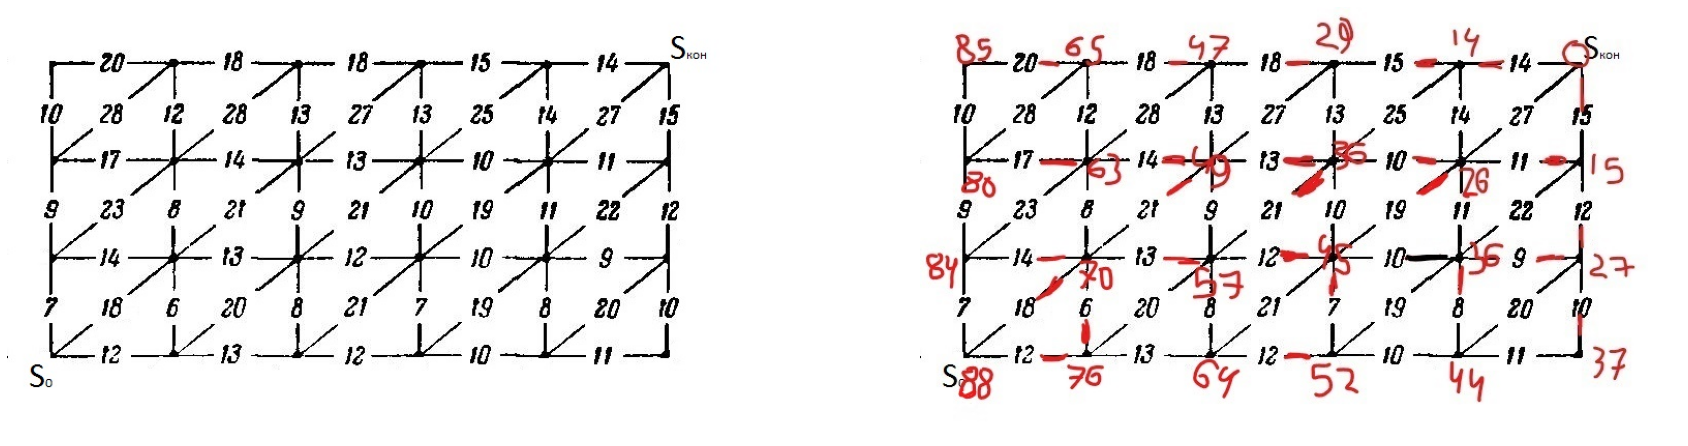

In [6]:
import matplotlib.pyplot as plt
import cv2

def get_optimal_path(point, directions_map, no_value = -1):
    """
    Возвращает путь от конкретной точки до конечной
    """
    points = [point]
    m, n = directions_map.shape
    no_value = bytes(str(no_value), encoding = 'utf-8')
    while True:
        direction = directions_map[point]
        if direction == bytes('up', encoding = 'utf-8'):
            point = (point[0]+1, point[1])
        elif direction == bytes('right', encoding = 'utf-8'):
            point = (point[0], point[1]+1)
        elif direction == bytes('diag', encoding = 'utf-8'):
            point = (point[0]+1, point[1]+1)
        points+=[point]
        
        if direction == no_value:
            return np.array(points)[:,::-1]
    return np.array(points)[:,::-1]

plt.figure(figsize = [30, 30])
plt.subplot(2,2,1)
plt.imshow(cv2.imread(os.path.join('data', 'hw-2.5.jpg'))[:,:,::-1])
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(cv2.imread(os.path.join('data', 'manually_hw-2.5.jpg'))[:,:,::-1])
plt.axis('off')
print()

Оптимальные затраты:  88.0


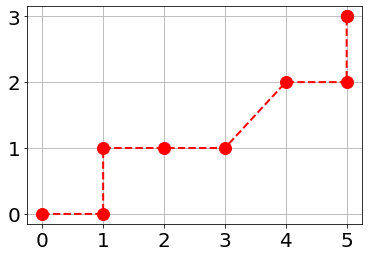

In [7]:
opt_path = get_optimal_path((0,0), directions_map)
plt.plot(opt_path[:,0], opt_path[:,1], 'ro--', linewidth=2, markersize=12)
plt.xticks(range(directions_map.shape[1]))
plt.yticks(range(directions_map.shape[0]))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid()
print('Оптимальные затраты: ', opt_cost[0,0])